# Day 12
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA test, CLR2

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10242374431573771272
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 0.705s 


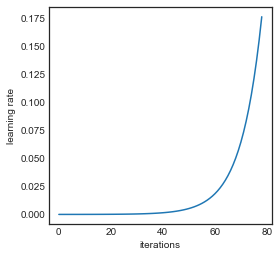

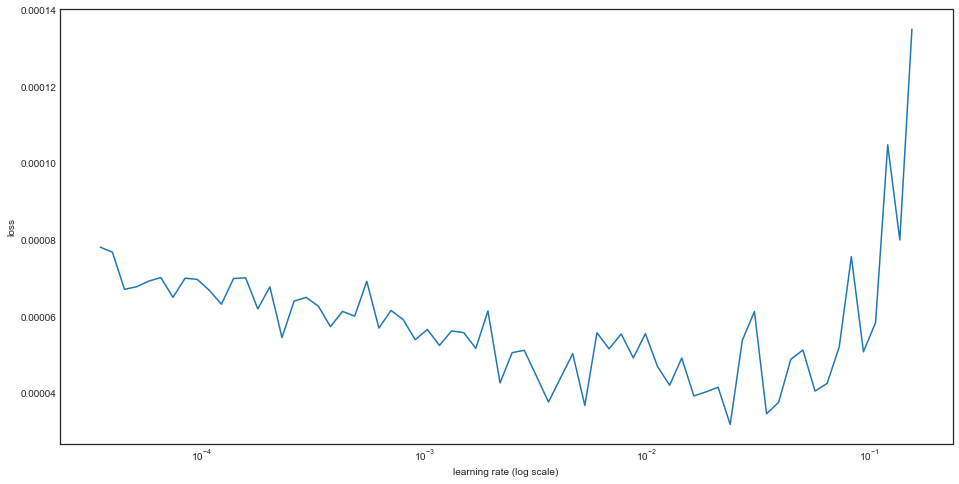

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [7]:
compileArgs['lr'] = 5e-3

## Train classifier

In [ ]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=-1,
                                          patience=2, cosAnnealMult=2, reduxDecay=True, trainOnWeights=True,
                                          maxEpochs=1, verbose=1)

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.6825190043571274e-05
2 New best found: 3.594349821213531e-05
3 New best found: 3.4763437797661024e-05
5 New best found: 3.4508869287172155e-05
6 New best found: 3.365507420201453e-05
7 New best found: 3.3582009925412554e-05
Score is: {'loss': 3.3582009925412554e-05, 'wAUC': 0.07027356263452189, 'AUC': 0.11369698534006445}
Fold took 6.181s

Running fold 2 / 10
1 New best found: 3.844102159557637e-05
2 New best found: 3.6509268178289355e-05
3 New best found: 3.532631017927788e-05
5 New best found: 3.5036104293885703e-05
6 New best found: 3.4309897647616814e-05
7 New best found: 3.428389857959746e-05
Score is: {'loss': 3.428389857959746e-05, 'wAUC': 0.0735470842290229, 'AUC': 0.11841881752927053}
Fold took 7.994s

Running fold 3 / 10
1 New best found: 3.710841591888351e-05
2 New best found: 3.530266791039553e-05
3 New best found: 3.518843674482404e-05
5 New best f

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"